[View in Colaboratory](https://colab.research.google.com/github/akxkcd/fattails/blob/master/kalman_filter_with_smoothing.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<h3> Generate Measurement Data <h3> 

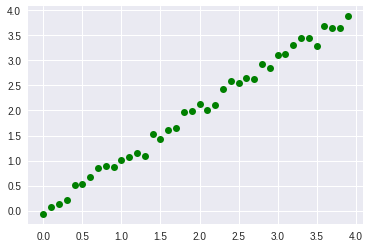

In [240]:
time_list = []
measurement_list = []
num_data = 40
dt = 0.1
for i in range(num_data):
  noise = np.random.normal(0, .1)
  time_list.append(i*dt)
  measurement_list.append(i*dt + noise)

plt.plot(time_list, measurement_list, 'go')
plt.show()

[Fixed lag smoothers](https://en.wikipedia.org/wiki/Kalman_filter#Fixed-lag_smoother)


Rauch–Tung–Striebel


In [0]:
class kalman_filter():
  
  def __init__(self):
    self.state = np.array([0., 0.]).T
    self.P = np.array([[1., 0.], [0., 1.]])
    self.last_time = 0.
    self.R = np.array([0.01])
    self.Q = np.array([[.01, 0.], [0., .01]])
    self.state_history = []
    self.P_history = []
    self.state_pre_history = []
    self.P_pre_history = []
    self.time_history = []
    
  def update_time(self, cur_time):
    delta_t = cur_time - self.last_time
    self.last_time = cur_time
    
    F = np.array([[1., delta_t], [0., 1.]])
    self.state = np.dot(F, self.state)
    self.P = np.dot(np.dot(F, self.P), F.T) + self.Q
    self.time_history.append(cur_time)
    self.state_pre_history.append(self.state)
    self.P_pre_history.append(self.P)
  
  def show(self):
    print("state:", self.state)
    print("P:", self.P)
    
  def update_measurement(self, measurement, display=False):
    H = np.array([1., 0.])
    # innovation
    y_k = measurement - np.dot(H, self.state)
    if display:
      print("y_k", y_k)
    
    # innovation covariance
    S_k = self.R + np.dot(np.dot(H, self.P), H.T)
    if display:
      print("S_k:", S_k)
    
    # kalman gain
    K_k = np.dot(self.P, H.T)/S_k
    if display:
      print("K_k:", K_k)
      
    # updated state
    self.state_delta = np.dot(K_k, y_k)
    self.state = self.state + self.state_delta
    if display:
      print("updated state:", self.state)
      
    # updated covariance
    K_dot_H = 1 - np.dot(K_k, H)
    self.P = np.dot(np.dot(K_dot_H, self.P), K_dot_H.T) + \
      np.dot(K_k, K_k.T)*self.R
    if display:
      print("updated covariance:", self.P)
    
    # measurement post-fit
    y_k = measurement - np.dot(H, self.state)
    # print(y_k)
    self.state_history.append(self.state)
    self.P_history.append(self.P)
    
  def smooth(self):
    self.smooth_state = []
    state_k_plus_1 = ""
    covar_k_plus_1 = ""
    state_k_plus_1_N = ""
    covar_k_plus_1_N = ""
    last_time = ""
    for i, s in reversed(list(enumerate(self.state_history))):
      if i == len(self.state_history) - 1:
        state_k_plus_1 = self.state_pre_history[i]
        covar_k_plus_1 = self.P_pre_history[i]
        state_k_plus_1_N = np.array([i*0.1-0.1, 1.]).T
        covar_k_plus_1_N = self.P_history[i]
        last_time = self.time_history[i]
        self.smooth_state.append(self.state_history[i])
        continue
      delta_t = last_time - self.time_history[i]
      F = np.array([[1., delta_t], [0., 1.]])
      state_k = self.state_history[i]
      covar_k = self.P_history[i]
      
      # Main RTS equations
      # Rest of code populates data-structures to compute these
      C_k = np.matmul(np.matmul(covar_k, F.T), np.linalg.inv(covar_k_plus_1))
      state_k_N = state_k + np.dot(C_k, state_k_plus_1_N - state_k_plus_1)
      covar_k_N = covar_k + np.matmul(np.matmul(C_k, covar_k_plus_1_N-covar_k_plus_1), C_k.T)
      
      state_k_plus_1 = self.state_pre_history[i]
      covar_k_plus_1 = self.P_pre_history[i]
      state_k_plus_1_N = state_k_N
      covar_k_plus_1_N = covar_k_N
      last_time = self.time_history[i]
      self.smooth_state.append(state_k_N)

In [0]:

filter = kalman_filter()

for t, d in zip(time_list, measurement_list):
  filter.update_time(t)
  filter.update_measurement(d, False)

states = np.array(filter.state_history).T

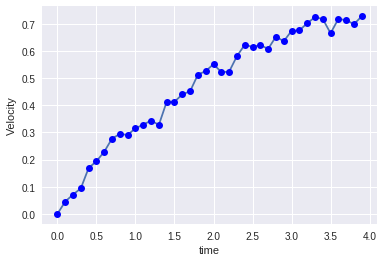

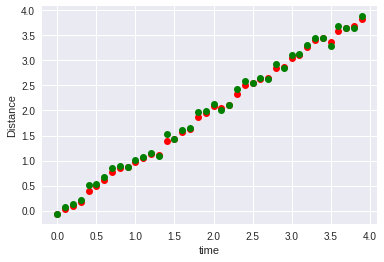

In [246]:
plt.plot(time_list, states[1])
plt.plot(time_list, states[1], 'bo')
plt.ylabel("Velocity")
plt.xlabel("time")
plt.show()
plt.ylabel("Distance")
plt.xlabel("time")
plt.plot(time_list, states[0], 'ro')
plt.plot(time_list, measurement_list, 'go')
# print(filter.P_history)

In [0]:
filter.smooth()


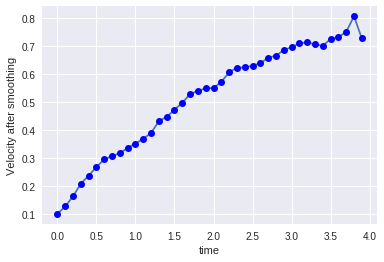

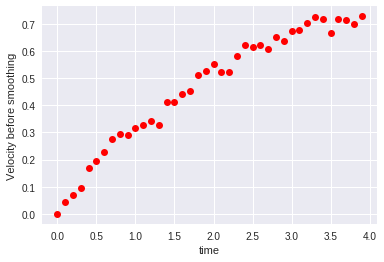

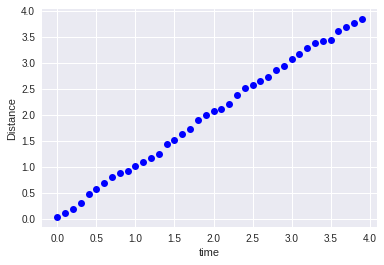

Text(0.5,0,'time')

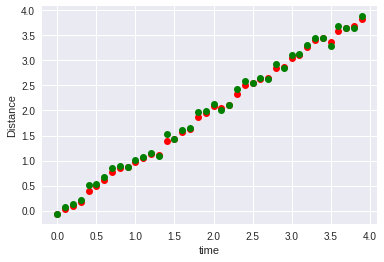

In [248]:
states = np.flip(np.array(filter.smooth_state).T, 1)
states_ = np.array(filter.state_history).T
plt.plot(time_list, states[1])
plt.plot(time_list, states[1], 'bo')
plt.ylabel("Velocity after smoothing")
plt.xlabel("time")
plt.show()
plt.plot(time_list, states_[1], 'ro')
plt.ylabel("Velocity before smoothing")
plt.xlabel("time")
plt.show()
plt.ylabel("Distance")
plt.xlabel("time")
plt.plot(time_list, (states[0]), 'bo')
plt.show()
plt.plot(time_list, states_[0], 'ro')
plt.plot(time_list, measurement_list, 'go')
plt.ylabel("Distance")
plt.xlabel("time")
